# Finding a reference for using scCODA on IBS microbiome data

We want to use scCODA to identify differentially abundant taxa in the gut microbiome of IBS patients.
Since we have data on different taxonomic level and from different datasets, we want a reference taxon that:

- is not rare (present in a majority of the samples, ~80%) on the genus level in all datasets
- has low dispersion of relative abundance in all datasets
- its "ancestors" (phylogenetic tree) also have low dispersion on their resp. levels in all datasets
- is not part of the Firmicutes phylum
- (optional) is not part of the Bacteroidota phylum

In [1]:
# setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sccoda.util.data_visualization as viz

import DA_analysis_util_functions as util
import importlib

In [2]:
# load genus datasets

authors = ["Fukui", "Hugerth", "Labus", "LoPresti", "Nagel", "Pozuelo", "Zeber", "Zhu", "Zhuang", "Liu", "AGP"]

datasets_genus = dict(zip(authors, [util.agg_ibs_data(a, "Genus") for a in authors]))

In [3]:
for k,v in datasets_genus.items():
    temp = v[v.obs["sample_type"] == "stool"]

    if k == "Pozuelo":
        temp = temp[temp.obs["Collection"] == "1st"]

    datasets_genus[k] = temp

In [4]:
# get all stats relevant for reference finding for a dataset:
def get_ref_stats(data, author, abundant_threshold=0.8):
    rel_abun = data.X / np.sum(data.X, axis=1, keepdims=True)

    percent_zero = np.sum(data.X == 0, axis=0) / data.X.shape[0]
    nonrare_ct = np.where(percent_zero < 1-abundant_threshold)[0]

    cell_type_disp = np.var(rel_abun, axis=0) / np.mean(rel_abun, axis=0)

    is_abundant = [x in nonrare_ct for x in range(data.X.shape[1])]

    plot_df = pd.DataFrame({
        "Total dispersion": cell_type_disp,
        "Cell type": data.var.index,
        "Presence": 1-percent_zero,
        "Is abundant": is_abundant,
        "Author": author,
    })

    return plot_df

# apply to all genus datasets
ref_stats = []
for a in authors:
    ref_stats.append(get_ref_stats(datasets_genus[a], a, abundant_threshold=0.75))

<ipython-input-4-08317aa9b4eb>:8: RuntimeWarning: invalid value encountered in divide
  cell_type_disp = np.var(rel_abun, axis=0) / np.mean(rel_abun, axis=0)


Aggregate this over all datasets. For each genus calculate:

- Is abundant (I(presence >= 0.8)):
    - number of occurences
    - Total number of datasets the genus is in
- Dispersion:
    - Mean
    - Median
    - Min value
    - Max value
- Presence:
    - Min value
    - Median

First look at genera that are not zero in the most datasets:

In [5]:
ref_stats_all = pd.concat(ref_stats)
ref_agg = ref_stats_all.groupby("Cell type").agg({
    "Is abundant": ["sum", "count"],
    "Total dispersion": ["mean", "median", "min", "max"],
    "Presence": ["min", "median"]
}).sort_values(("Is abundant", "sum"), ascending=False)

print(ref_agg.head(50))

                                                   Is abundant        \
                                                           sum count   
Cell type                                                              
Bacteria*Bacteroidota*Bacteroidia*Bacteroidales...          11    11   
Bacteria*Firmicutes*Clostridia*Oscillospirales*...          11    11   
Bacteria*Firmicutes*Clostridia*Lachnospirales*L...           9    11   
Bacteria*Firmicutes*Clostridia*Lachnospirales*L...           8    11   
Bacteria*Firmicutes*Clostridia*Lachnospirales*L...           8    11   
Bacteria*Bacteroidota*Bacteroidia*Bacteroidales...           8    11   
Bacteria*Actinobacteriota*Actinobacteria*Bifido...           8     9   
Bacteria*Bacteroidota*Bacteroidia*Bacteroidales...           8    11   
Bacteria*Firmicutes*Clostridia*Lachnospirales*L...           7    11   
Bacteria*Firmicutes*Clostridia*Lachnospirales*L...           7    11   
Bacteria*Firmicutes*Clostridia*Lachnospirales*L...           7  

We want a reference that is present in all datasets. There are only a few genera that fulfil this criterion and are not Firmicutes:

As candidates, we select the three non-Bacteroidota or Firmicutes genera.

In [6]:
candidate_taxon_genera = ref_agg[(ref_agg[("Is abundant", "count")] == 11) & ~((ref_agg.index.str.startswith("Bacteria*Firmicutes")) | (ref_agg.index.str.startswith("Bacteria*Bacteroidota")))]
print(candidate_taxon_genera)

print("")
candidate_taxon_genus_2 = candidate_taxon_genera.index[0]
print(candidate_taxon_genus_2)
candidate_taxon_genus_3 = candidate_taxon_genera.index[1]
print(candidate_taxon_genus_3)

candidate_taxon_genus_4 = candidate_taxon_genera.index[2]
print(candidate_taxon_genus_4)


                                                   Is abundant        \
                                                           sum count   
Cell type                                                              
Bacteria*Proteobacteria*Gammaproteobacteria*Ent...           2    11   
Bacteria*Proteobacteria*Gammaproteobacteria*Bur...           0    11   
Bacteria*Actinobacteriota*Coriobacteriia*Coriob...           0    11   

                                                   Total dispersion            \
                                                               mean    median   
Cell type                                                                       
Bacteria*Proteobacteria*Gammaproteobacteria*Ent...         0.144598  0.079977   
Bacteria*Proteobacteria*Gammaproteobacteria*Bur...         0.029523  0.032320   
Bacteria*Actinobacteriota*Coriobacteriia*Coriob...         0.003337  0.003346   

                                                                        \
      

Candidate 1: High dispersion for Hugerth, LoPresti, AGP --> Bad!

In [7]:
print(candidate_taxon_genus_2)
print(ref_stats_all[ref_stats_all["Cell type"] == candidate_taxon_genus_2])

Bacteria*Proteobacteria*Gammaproteobacteria*Enterobacterales*Enterobacteriaceae*Escherichia/Shigella
    Total dispersion                                          Cell type  \
39          0.025305  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
1           0.330891  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
52          0.008986  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
1           0.368177  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
15          0.079977  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
10          0.189502  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
21          0.061684  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
44          0.011786  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
12          0.038107  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
4           0.166086  Bacteria*Proteobacteria*Gammaproteobacteria*En...   
32          0.310082  Bacteria*Proteobacteria*Gammaproteobacteria*En...   

Candidate 2: Looks quite ok. Only low presence for LoPresti, only DA for Zhu (kinda irrelevant, as we know)
**-> Take this one!**

In [8]:
print(candidate_taxon_genus_3)
print(ref_stats_all[ref_stats_all["Cell type"] == candidate_taxon_genus_3])

Bacteria*Proteobacteria*Gammaproteobacteria*Burkholderiales*Sutterellaceae*Parasutterella
    Total dispersion                                          Cell type  \
26          0.032320  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
58          0.033044  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
19          0.048050  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
82          0.001310  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
24          0.027578  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
31          0.011087  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
25          0.040397  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
39          0.017467  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
20          0.054309  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
34          0.043201  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   
78          0.015993  Bacteria*Proteobacteria*Gammaproteobacteria*Bu...   

    Prese

Candidate 3: Mostly very low presence --> Bad!

In [9]:
print(candidate_taxon_genus_4)
print(ref_stats_all[ref_stats_all["Cell type"] == candidate_taxon_genus_4])

Bacteria*Actinobacteriota*Coriobacteriia*Coriobacteriales*Eggerthellaceae*Slackia
     Total dispersion                                          Cell type  \
105          0.004688  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
131          0.003346  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
81           0.004111  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
79           0.006841  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
82           0.004370  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
189          0.000384  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
146          0.001681  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
93           0.000471  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
90           0.000772  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
85           0.008904  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   
155          0.001136  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   

     

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


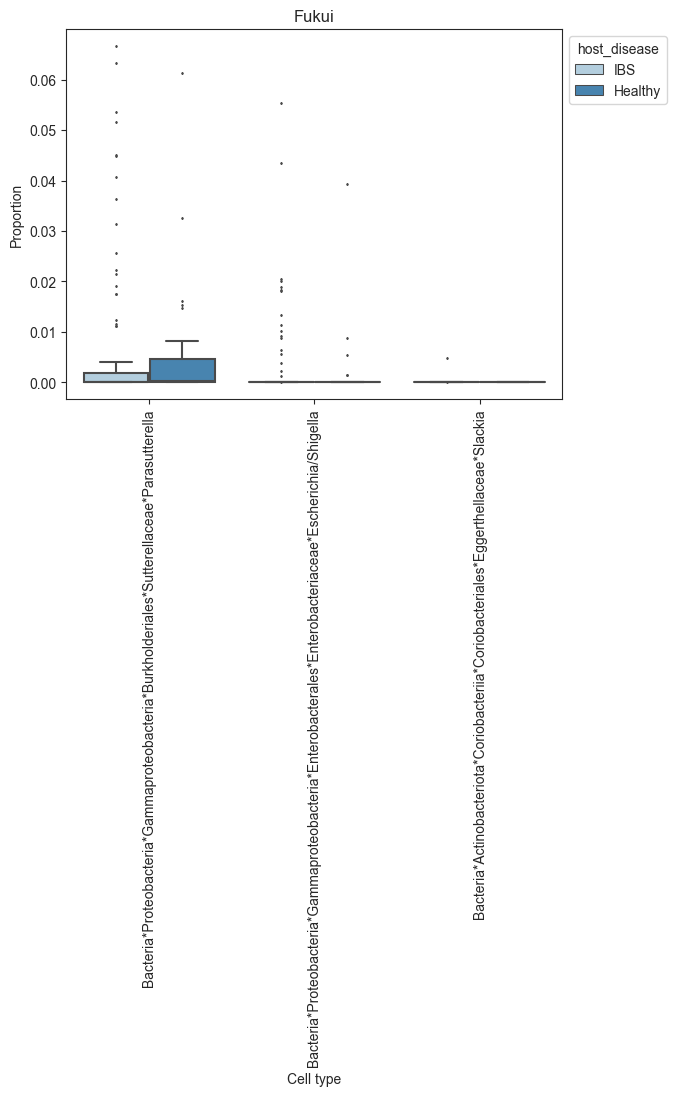

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


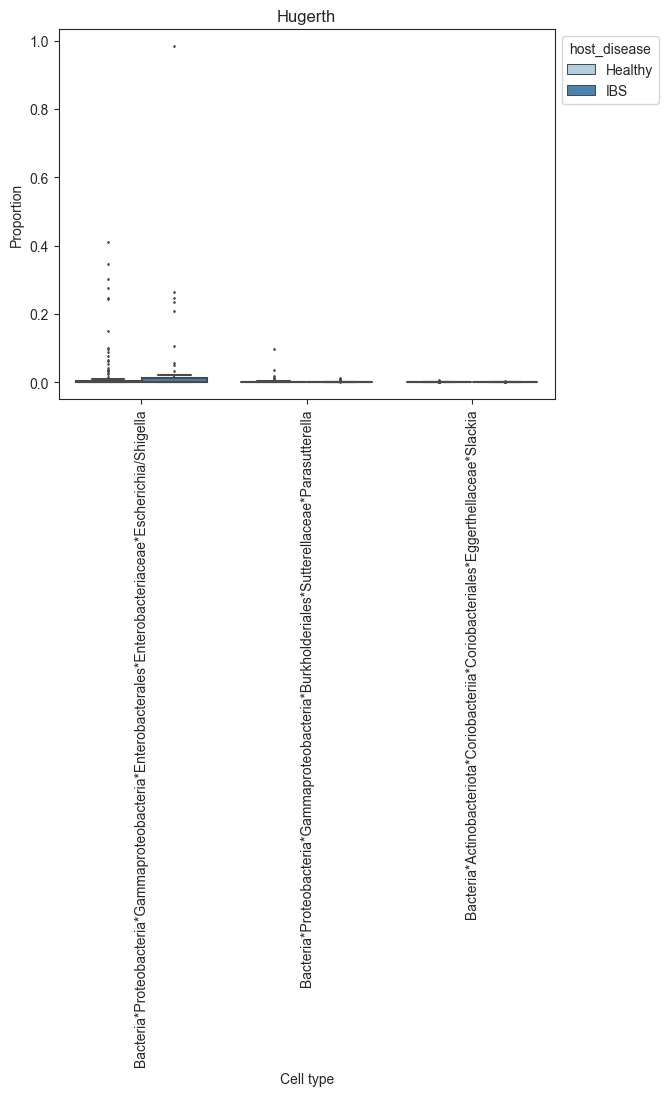

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


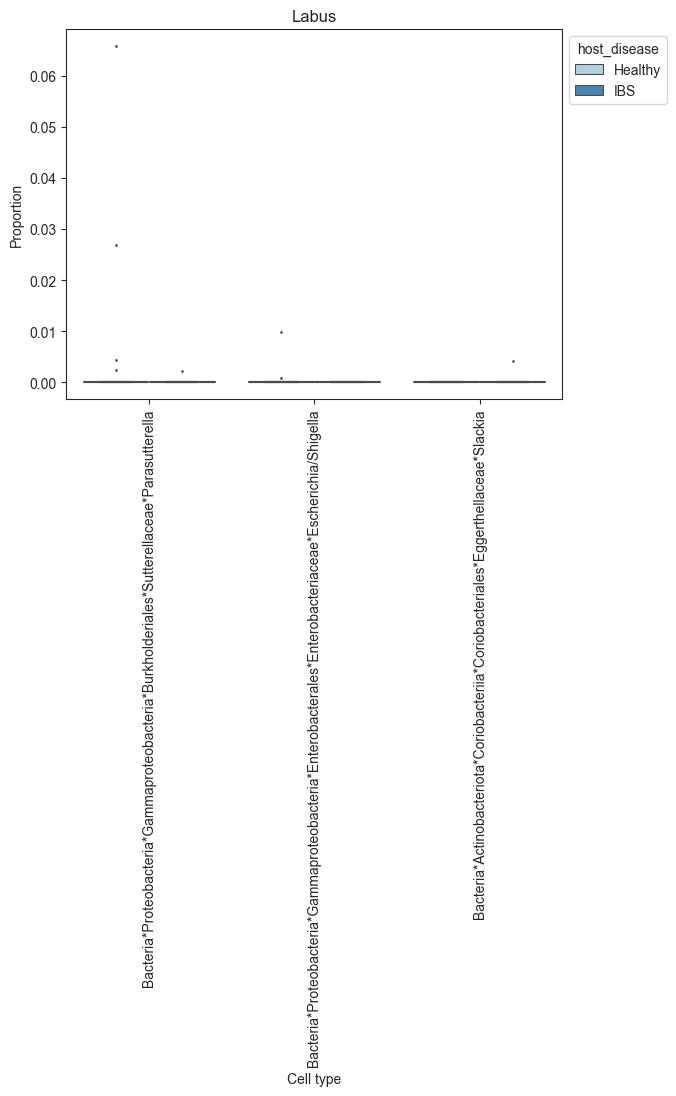

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


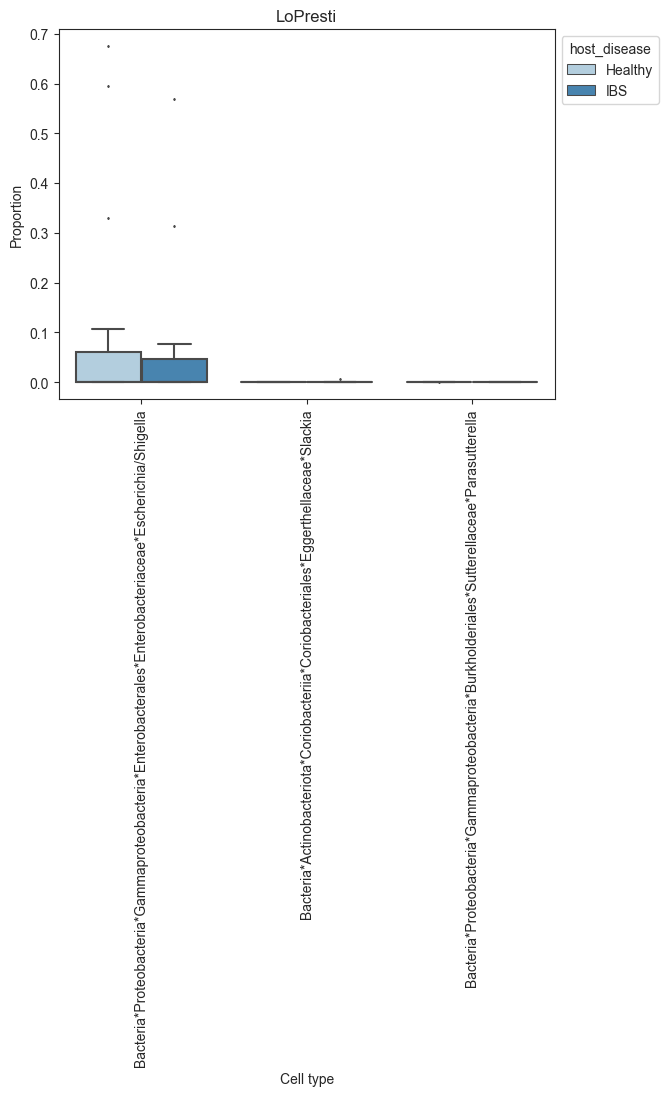

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


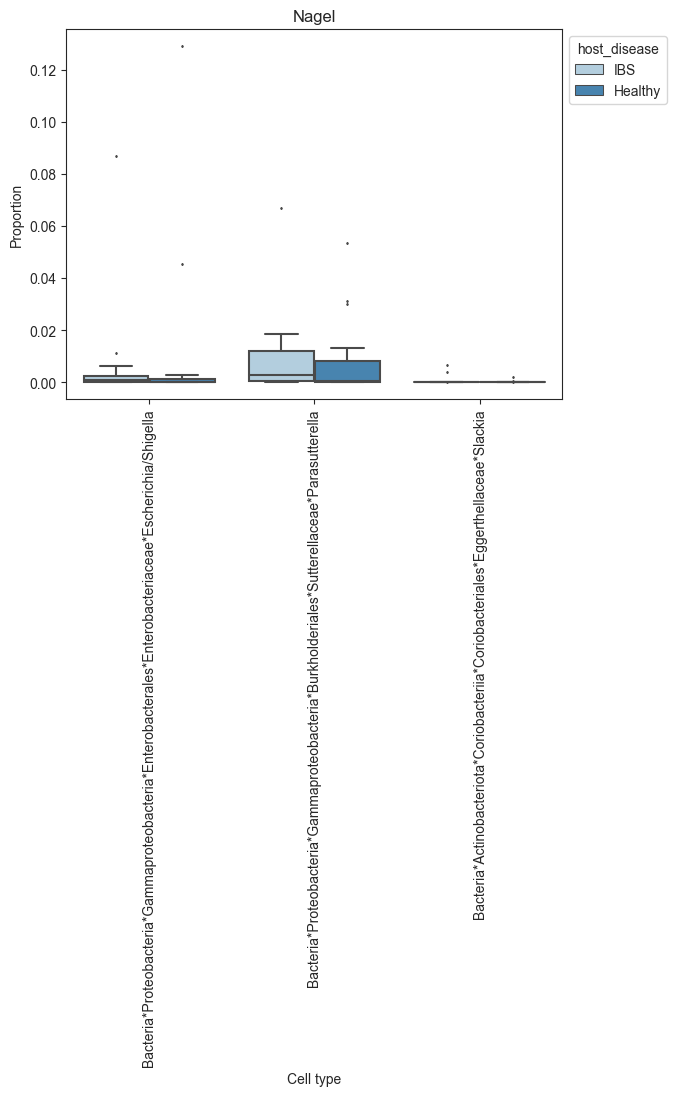

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


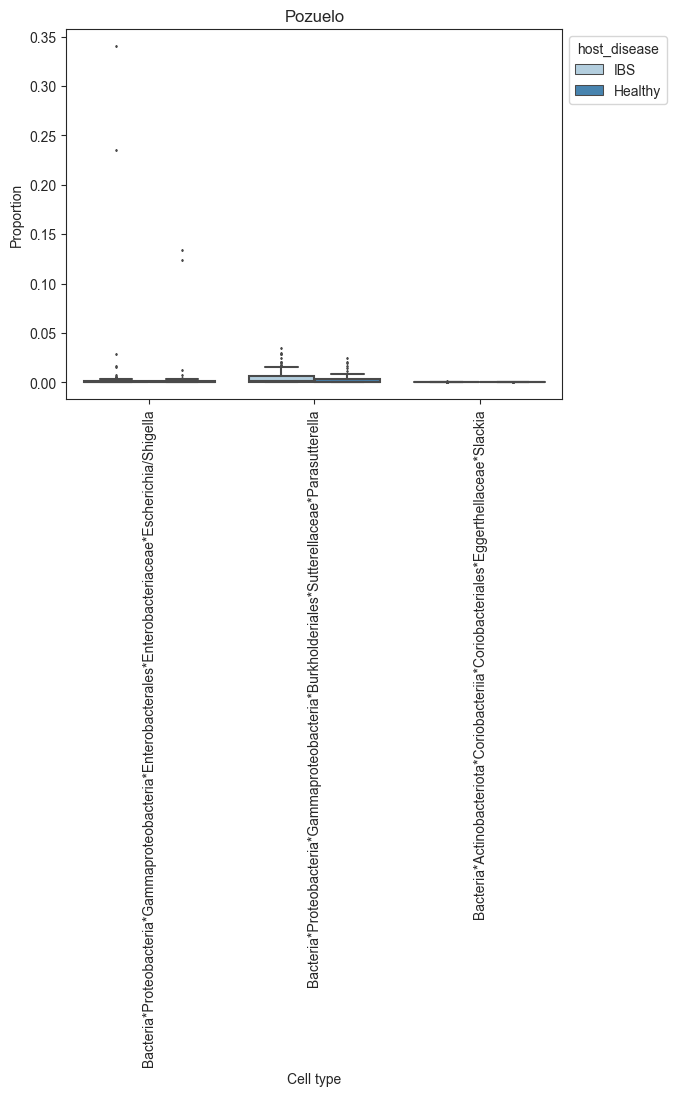

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


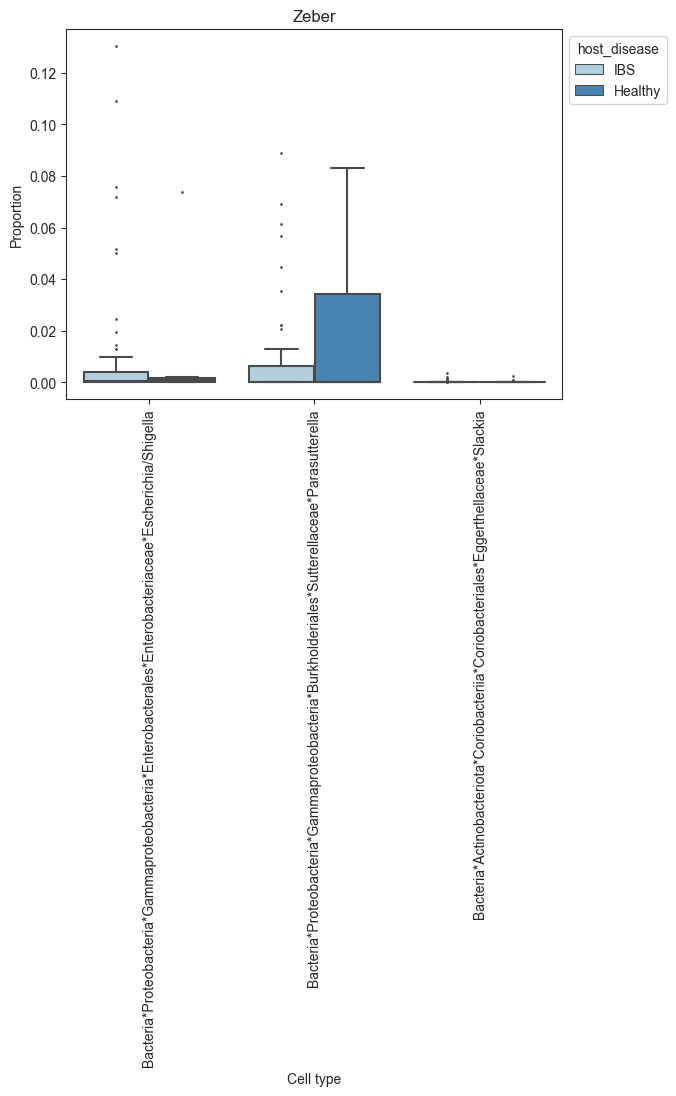

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


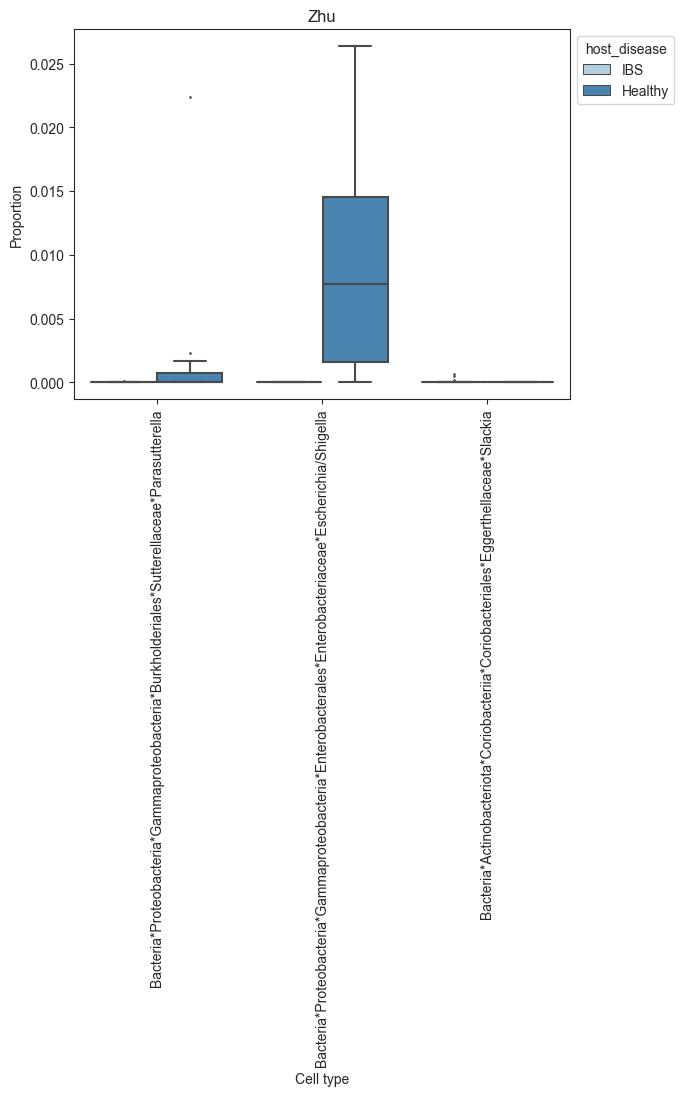

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


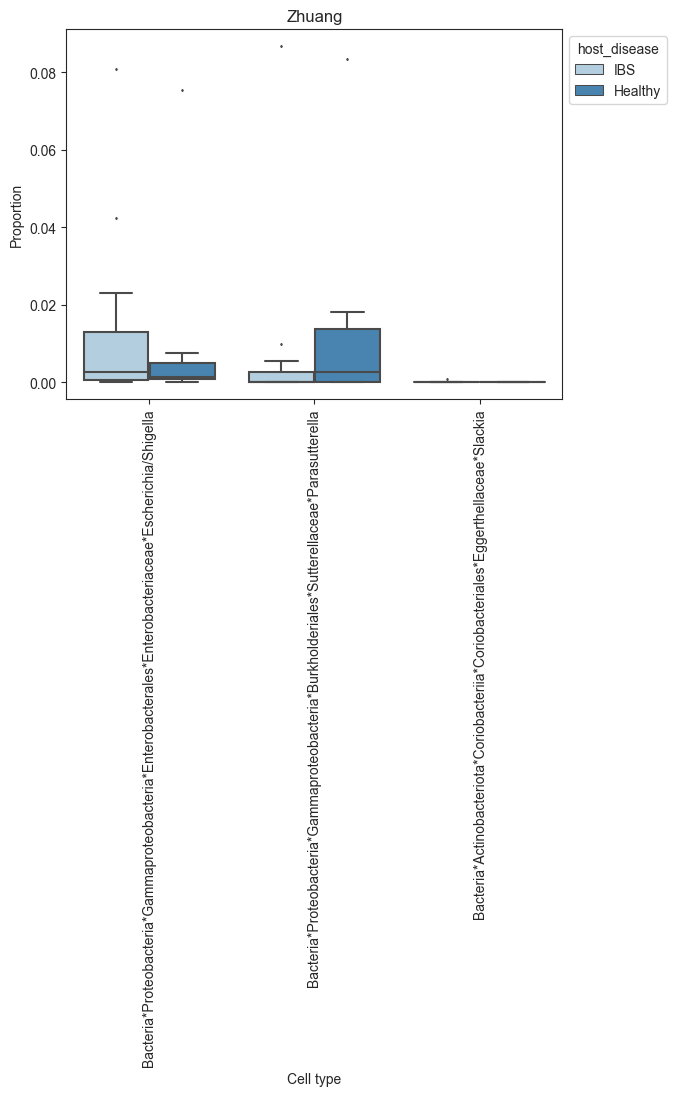

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


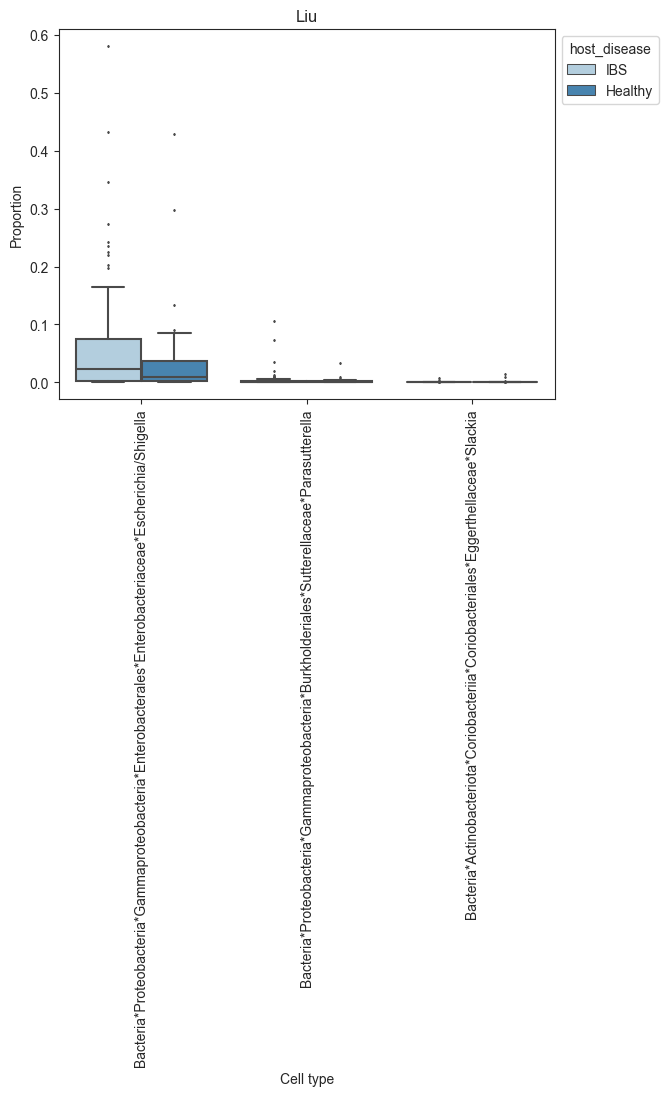

/Users/johannes.ostner/Documents/PhD/scCODA/scCODA/sccoda/util/data_visualization.py:347: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


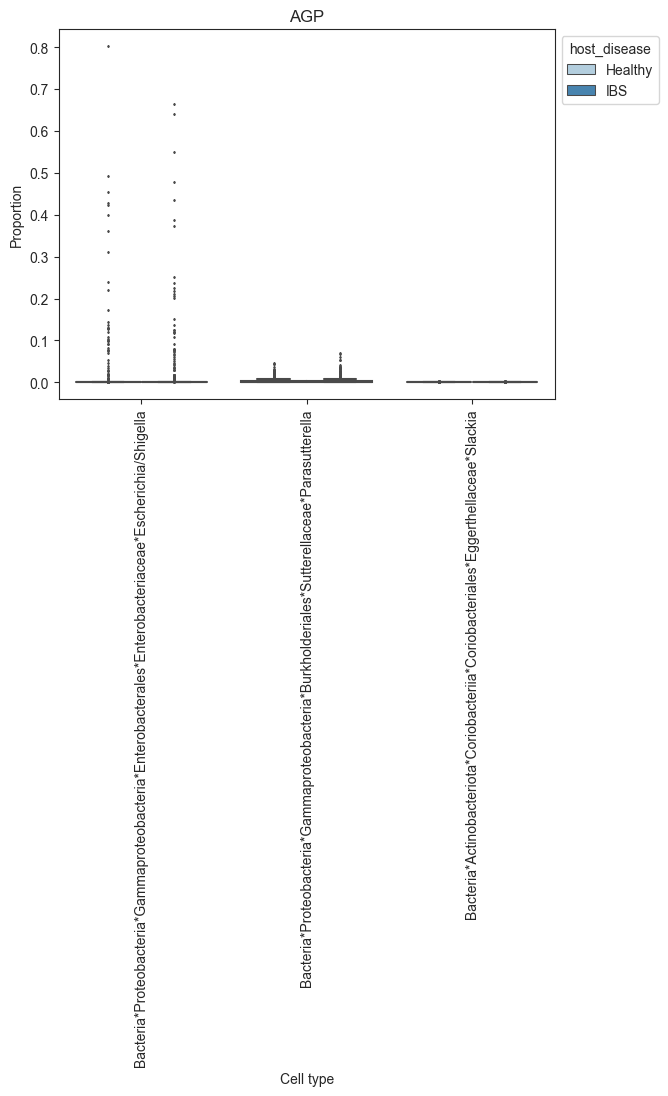

In [10]:
importlib.reload(viz)

for a in authors:
    ax = viz.boxplots(datasets_genus[a], "host_disease", cell_types=[
        candidate_taxon_genus_2,
        candidate_taxon_genus_3,
        candidate_taxon_genus_4,

    ])
    plt.title(a)
    plt.show()

### Aggregate results for supplementary table

In [11]:
latex_tab = ref_stats_all.loc[
    ref_stats_all["Cell type"].isin([candidate_taxon_genus_2, candidate_taxon_genus_3, candidate_taxon_genus_4]),
    ["Cell type", "Author", "Total dispersion", "Presence"]
]
latex_tab = latex_tab.sort_values("Cell type")
latex_tab["Cell Type"] = [x.split("*")[-1] for x in latex_tab["Cell type"]]


print(latex_tab)

                                             Cell type    Author  \
155  Bacteria*Actinobacteriota*Coriobacteriia*Corio...       AGP   
85   Bacteria*Actinobacteriota*Coriobacteriia*Corio...       Liu   
105  Bacteria*Actinobacteriota*Coriobacteriia*Corio...     Fukui   
90   Bacteria*Actinobacteriota*Coriobacteriia*Corio...    Zhuang   
131  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   Hugerth   
93   Bacteria*Actinobacteriota*Coriobacteriia*Corio...       Zhu   
81   Bacteria*Actinobacteriota*Coriobacteriia*Corio...     Labus   
79   Bacteria*Actinobacteriota*Coriobacteriia*Corio...  LoPresti   
146  Bacteria*Actinobacteriota*Coriobacteriia*Corio...     Zeber   
189  Bacteria*Actinobacteriota*Coriobacteriia*Corio...   Pozuelo   
82   Bacteria*Actinobacteriota*Coriobacteriia*Corio...     Nagel   
34   Bacteria*Proteobacteria*Gammaproteobacteria*Bu...       Liu   
20   Bacteria*Proteobacteria*Gammaproteobacteria*Bu...    Zhuang   
39   Bacteria*Proteobacteria*Gammaproteobacteria

In [12]:
print(latex_tab.to_latex(columns=["Cell Type", "Author", "Total dispersion", "Presence"], float_format="%.3f", index=False))

\begin{tabular}{llrr}
\toprule
           Cell Type &   Author &  Total dispersion &  Presence \\
\midrule
             Slackia &      AGP &             0.001 &     0.143 \\
             Slackia &      Liu &             0.009 &     0.086 \\
             Slackia &    Fukui &             0.005 &     0.018 \\
             Slackia &   Zhuang &             0.001 &     0.033 \\
             Slackia &  Hugerth &             0.003 &     0.161 \\
             Slackia &      Zhu &             0.000 &     0.138 \\
             Slackia &    Labus &             0.004 &     0.019 \\
             Slackia & LoPresti &             0.007 &     0.022 \\
             Slackia &    Zeber &             0.002 &     0.200 \\
             Slackia &  Pozuelo &             0.000 &     0.095 \\
             Slackia &    Nagel &             0.004 &     0.200 \\
      Parasutterella &      Liu &             0.043 &     0.586 \\
      Parasutterella &   Zhuang &             0.054 &     0.500 \\
      Parasutterella &